# Calibración de la Cámara

## Introducción

La calibración de cámara es un proceso fundamental en la visión por computadora que permite determinar las propiedades intrínsecas y extrínsecas de una cámara. Estas propiedades son necesarias para entender cómo una cámara captura una escena en el mundo real y cómo esta escena se representa en una imagen. La calibración es esencial en aplicaciones donde se requiere precisión geométrica, como la reconstrucción 3D ya que la camara toma imágenes en perspectiva y con distorsiones como la de ojo de pez.

Uno de los métodos más comunes para la calibración de cámaras es el uso de un tablero de ajedrez (o tablero de damas). Este tablero proporciona un patrón regular y fácilmente reconocible, lo que facilita la detección automática de puntos clave en las imágenes. El proceso involucra capturar múltiples imágenes del tablero desde diferentes ángulos y distancias, lo que permite calcular las distorsiones de la lente y otros parámetros de la cámar

En este notebook se va a realizar una implementación del calibrado de cámara gracias a la libreria de open-cv.a.

## Instalacion de librerias

Se considera que este notebook esta siendo ejecutado en el entorno jupyter de anaconda

In [1]:
#!pip install opencv-python
#!pip install matplotlib
#!pip install glob
#!pip install numpy


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import cv2
cv = cv2
import glob
import numpy as np
import sympy as sp


### Pantilla con el Tablero estilo ajedrez

Aunque existen distintos tipos de tamaño de plantilla en este caso vamos a usar la plantilla de 9x6 que es la de mayor numero de cuadros lo que ayuda a open cv a detectar mejor la distorsión de la cámara.
A continuación se muestra la plantilla, esta se puede imprimir en papel o mostrar en una pantalla. Lo importante es que en la imagen se vea al completo.

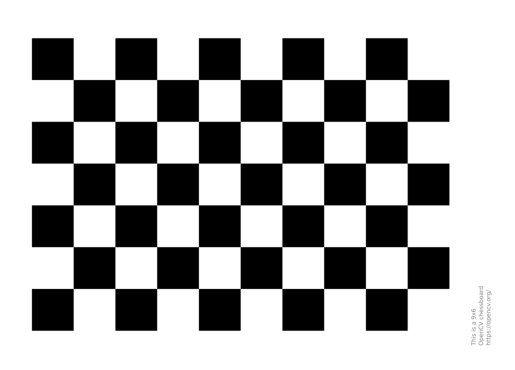

In [3]:
pattern = plt_img.imread('img/pattern.png')
plt.axis('off')
plt.imshow(pattern)
plt.show()

### Mostrando las Imágenes del Tablero

En primer lugar, se mostrarán las imágenes capturadas del tablero de ajedrez. Estas imágenes se utilizarán para detectar automáticamente los puntos clave del patrón del tablero. La correcta detección de estos puntos es crucial para una calibración precisa. Mientras mayor número de imágenes más lento será el proceso pero mejor la precisión del algoritmo.


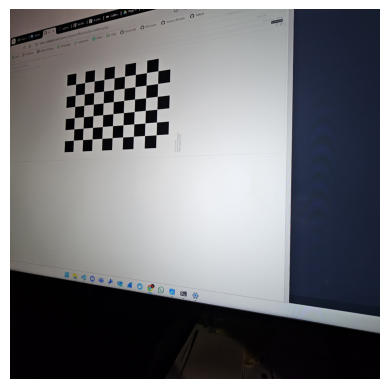

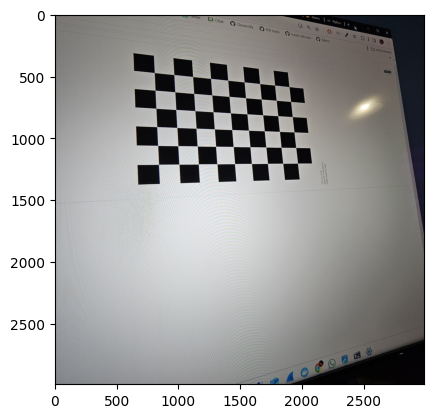

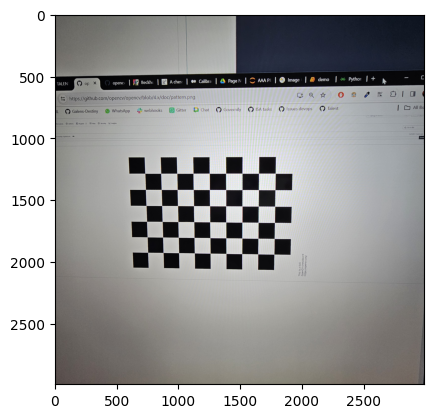

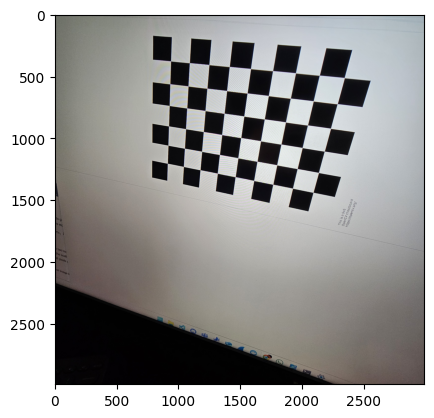

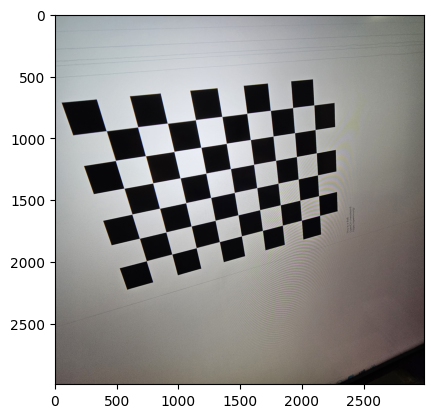

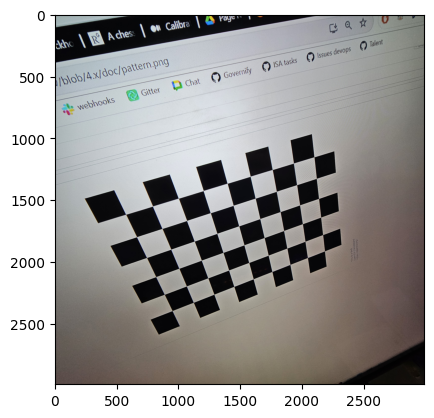

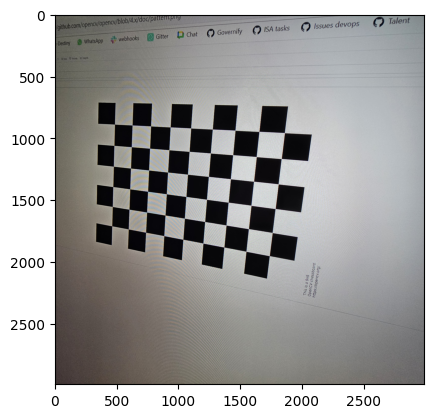

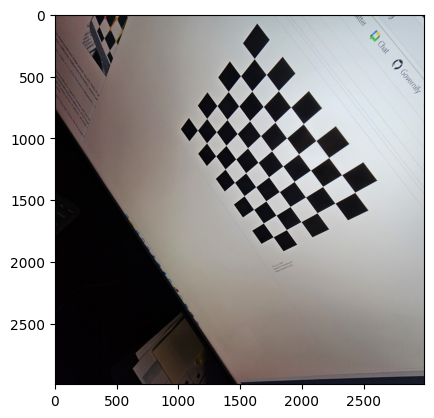

In [4]:
plt.axis('off')  
images_paths = glob.glob('img/angular-1to1/*_*.jpg')
for file_name in images_paths:
    color_image = plt_img.imread(file_name)
    gray_image = cv2.imread(file_name,0)
    plt.imshow(color_image)
    plt.show()
    # threshold, binarized_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    # plt.imshow(binarized_image,cmap="gray")
    # plt.show()
    

### Introducción a la Función de Calibración

La función de calibración que vamos a utilizar se llama `scanner_calibrate_camera`. Esta función toma como entrada una ruta a las imágenes del tablero de ajedrez y un parámetro opcional para mostrar o no las imágenes procesadas. La función sigue los siguientes pasos:

1. Define el número de filas y columnas del tablero de ajedrez.
2. Establece los criterios de terminación para el algoritmo de refinamiento de esquinas.
3. Prepara los puntos de objeto en un espacio tridimensional real.
4. Inicializa listas para almacenar puntos de objeto y puntos de imagen.
5. Carga cada imagen del directorio especificado y convierte la imagen a escala de grises.
6. Detecta los puntos de las esquinas del tablero de ajedrez en la imagen.
7. Refina la detección de esquinas y almacena los puntos de objeto y de imagen.
8. Si se detectan las esquinas correctamente, se dibujan y muestran en la imagen.
9. Finalmente, la función calibra la cámara utilizando los puntos detectados y devuelve los parámetros de calibración: la matriz de la cámara, los coeficientes de distorsión, los vectores de rotación y los vectores de traslación.


In [5]:
def scanner_calibrate_camera(path='img/calibrate/showcase/angular.png', show_images=False):
    #---------------------------------PARÁMETROS
    rows_count = 6
    columns_count = 9
    #---------------------------------
    # Criterios de terminación
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    # Preparar puntos del objeto, como (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows_count*columns_count, 3), np.float32)
    objp[:, :2] = np.mgrid[0:columns_count, 0:rows_count].T.reshape(-1, 2)
    # Arrays para almacenar puntos del objeto y puntos de la imagen de todas las imágenes.
    objpoints = [] # Puntos 3D en el espacio del mundo real
    imgpoints = [] # Puntos 2D en el plano de la imagen
    images = glob.glob(path)
    print("Cargando imágenes: ", images)
    for fname in images:
        print("Cargando imagen: " + fname)
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Encontrar las esquinas del tablero de ajedrez
        ret, corners = cv.findChessboardCorners(gray, (columns_count, rows_count), None)
        # Si se encuentran, añadir puntos del objeto, puntos de la imagen (después de refinarlos)
        if ret == True:
            print(fname + ": calibración exitosa")
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            # Dibujar y mostrar las esquinas
            cv.drawChessboardCorners(img, (columns_count, rows_count), corners2, ret)
            if show_images:
                plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                plt.axis("off")
                plt.show()
        else:
            print(fname + ": tablero de ajedrez no encontrado")

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs


### Probar la Detección del Tablero
A continuación, vamos a probar la detección del tablero de ajedrez con una imagen tomada con una cámara con ojo de pez. Esta prueba nos permitirá verificar que la detección de esquinas funciona correctamente y que se pueden obtener los parámetros de calibración de la cámara.

Cargando imágenes:  ['img/angular.png']
Cargando imagen: img/angular.png
img/angular.png: calibración exitosa


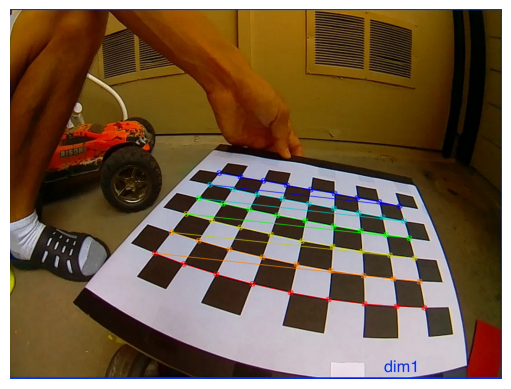

In [6]:
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(path='img/angular.png',show_images=True)

In [7]:
print("Parámetros de la cámara:")
display(sp.Matrix(mtx))
print("Vectores de rotación:")
display(sp.Matrix(rvecs[0]))

Parámetros de la cámara:


Matrix([
[495.390246378042,                0, 507.593378784088],
[               0, 479.484346473456, 344.888121468607],
[               0,                0,              1.0]])

Vectores de rotación:


Matrix([
[ -0.1341299491606],
[-1.40731318409528],
[-2.51013874719021]])

### Obtener la Nueva Matriz de la Cámara
Una vez que hemos obtenido los parámetros de calibración, el siguiente paso es calcular la nueva matriz de la cámara. Esto nos ayudará a mejorar la precisión de las imágenes corregidas por distorsión.

In [8]:
img = cv.imread('img/angular.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

### Corregir la Distorsión de la Imagen
Ahora, vamos a aplicar la corrección de la distorsión a la imagen original utilizando los parámetros de calibración obtenidos. Además, recortaremos la imagen para eliminar las áreas no deseadas.

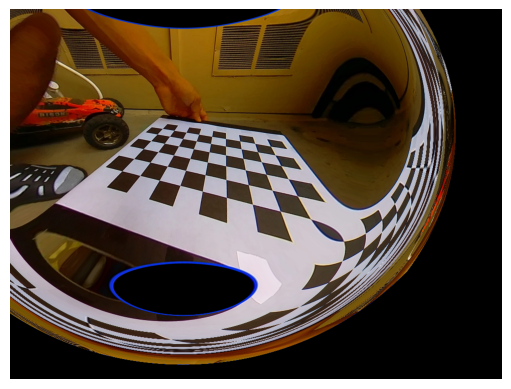

In [9]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
cv.imwrite('img/calibration-undistort.png', dst)
undist = plt_img.imread('img/calibration-undistort.png')
plt.axis('off')
plt.imshow(undist)
plt.show()

### Resultado Final
Después de completar los pasos anteriores, hemos logrado calibrar la cámara y corregir la distorsión de la imagen. La imagen resultante se ha guardado como calibration-result.png. Esta imagen debería mostrar una versión mejorada y corregida de la imagen original, con las distorsiones ópticas eliminadas.

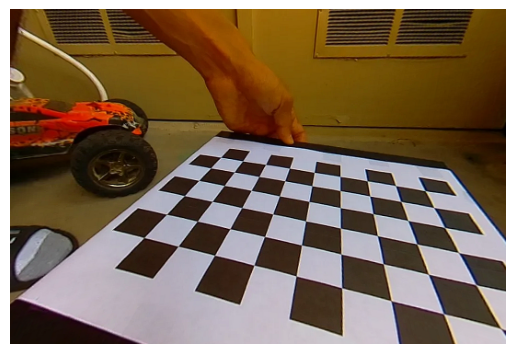

In [10]:
# recortar la imagen
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('img/calibration-result.png', dst)
res = plt_img.imread('img/calibration-result.png')
plt.axis('off')
plt.imshow(res)
plt.show()

## Experimentación

### Obtener la Matriz de la Cámara Usando Parámetros Conocidos

Los parámetros de la cámara se pueden encontrar en la web. En nuestro caso, vamos a utilizar los parámetros de la cámara Samsung S23 Ultra, específicamente la cámara del zoom 10x en su mínimo zoom.


In [19]:


# Constantes y suposiciones
pixel_size_um = 1.12  # tamaño de píxel en micrómetros
sensor_width_mm = 4.5  # ancho del sensor en mm, típico para un sensor de 1/3.52"
focal_length_mm = 70  # longitud focal asumida en mm para una lente telefoto con zoom óptico de 3x

# Calcular la resolución basada en el tamaño del sensor y el tamaño del píxel
# Convertir el tamaño del píxel a mm
pixel_size_mm = pixel_size_um / 1000

# Calcular el ancho y la altura de la imagen en píxeles (asumiendo una relación de aspecto 4:3 para un sensor típico)
image_width_pixels = int(sensor_width_mm / pixel_size_mm)
image_height_pixels = int(3/4 * image_width_pixels)

# Calcular las longitudes focales en unidades de píxeles
f_x_pixels = focal_length_mm / sensor_width_mm * image_width_pixels
f_y_pixels = f_x_pixels  # asumiendo píxeles cuadrados, por lo que f_x = f_y

# Punto principal asumido en el centro de la imagen
c_x = image_width_pixels / 2
c_y = image_height_pixels / 2

# Matriz intrínseca de la cámara
camera_matrix = np.array([
    [f_x_pixels, 0, c_x],
    [0, f_y_pixels, c_y],
    [0, 0, 1]
])

display(sp.Matrix(camera_matrix))


Matrix([
[62486.6666666667,                0, 2008.5],
[               0, 62486.6666666667, 1506.0],
[               0,                0,    1.0]])

### Explicación de la Matriz Intrínseca de la Cámara

La matriz intrínseca de la cámara es una representación matemática que relaciona las coordenadas del mundo real con las coordenadas de la imagen en píxeles. En términos simples, esta matriz nos ayuda a entender cómo una cámara proyecta un punto 3D del mundo real en un punto 2D en la imagen. La matriz tiene la siguiente forma:

\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix} 

Donde:
- \( f_x \) y \( f_y \) son las longitudes focales en términos de píxeles en las direcciones x e y, respectivamente. Estas se calculan utilizando la longitud focal real de la lente (en milímetros) y el tamaño del sensor.
- \( c_x \) y \( c_y \) son las coordenadas del punto principal (también conocido como el centro óptico) de la imagen, que generalmente se asume que están en el centro de la imagen.
- El valor 1 en la tercera fila y tercera columna es una constante que permite la transformación de coordenadas homogéneas.

Esta matriz es fundamental para tareas como la calibración de la cámara, la corrección de distorsiones y la reconstrucción 3D, ya que encapsula la forma en que la cámara captura la realidad.
